Import packages

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
import datetime as dt

Import data

In [7]:
df = pds.read_csv('../../bus203_all_labelled.csv')

# Ignore all other stuff than the ObservedPositionEvent
df = df[df['event'] == "ObservedPositionEvent"]

One hot encode segments, normalize columns and create final dataset

In [ ]:
# Make segments categorical
dataset = pds.get_dummies(df['segment_number'])

# Combine segments, timestamps and time from journey start

# Cyclical timestamps 
dataset['hr_sin'] = np.sin(df.timestamp.str[11:13].astype(int)*(2.*np.pi/24))
dataset['hr_cos'] = np.cos(df.timestamp.str[11:13].astype(int)*(2.*np.pi/24))

# Convert to radians befor trigonometric functions
dataset['dir_sin'] = np.sin(df.direction*(np.pi/180))
dataset['dir_cos'] = np.cos(df.direction*(np.pi/180))

dataset['speed'] = (df['speed']-df['speed'].min())/(df['speed'].max()-df['speed'].min())
dataset['time_since_journey_start'] = (df['time_since_journey_start']-df['time_since_journey_start'].min())/(df['time_since_journey_start'].max()-df['time_since_journey_start'].min())

dataset['latitude'] = (df['latitude']-df['latitude'].min())/(df['latitude'].max()-df['latitude'].min())
dataset['longitude'] = (df['longitude']-df['longitude'].min())/(df['longitude'].max()-df['longitude'].min())

In [23]:
dataset.head(5)

,1,2,3,4,5,6,7,8,9,10,11,hr_sin,hr_cos,dir_sin,dir_cos,speed,time_since_journey_start,latitude,longitude
1,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326317,0.924521
3,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326237,0.925287
4,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326156,0.925670
5,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326076,0.926437
6,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326116,0.926437


Divide training and test data, 80% training data

In [24]:
msk = np.random.rand(len(df))<0.8
train_input = dataset[msk]
test_input = dataset[~msk]

train_labels = df['label'][msk]
test_labels = df['label'][~msk]

Build model

In [26]:
model = keras.Sequential([
	keras.layers.Dense(len(train_input.columns), activation=tf.nn.relu, input_shape=(train_input.shape[1],)),
    keras.layers.Dense(3),
	keras.layers.Dense(1)
	])

optimizer = tf.train.RMSPropOptimizer(0.001)
model.compile(loss='mae', optimizer = optimizer, metrics=['mae'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 60        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 4         
Total params: 444
Trainable params: 444
Non-trainable params: 0
_________________________________________________________________
None


Fit model

In [27]:
EPOCHS=5
model.fit(train_input.values, train_labels.values, epochs = EPOCHS)

Epoch 1/5
2648563/2648563 [==============================] - 40s 15us/step - loss: 17.7784 - mean_absolute_error: 17.7784
Epoch 2/5
2648563/2648563 [==============================] - 39s 15us/step - loss: 17.0252 - mean_absolute_error: 17.0252
Epoch 3/5
2648563/2648563 [==============================] - 39s 15us/step - loss: 16.9870 - mean_absolute_error: 16.9870
Epoch 4/5
2648563/2648563 [==============================] - 39s 15us/step - loss: 16.9437 - mean_absolute_error: 16.9437
Epoch 5/5
2648563/2648563 [==============================] - 40s 15us/step - loss: 16.9005 - mean_absolute_error: 16.9005


Evaluate model

In [28]:
model.evaluate(test_input.values, test_labels.values)

663437/663437 [==============================] - 5s 7us/step


[16.93936129783793, 16.93936129783793]

Plot predictions

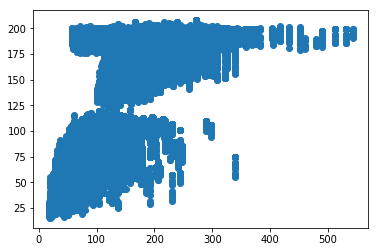

In [29]:
test_predictions = model.predict(test_input.values)
plt.scatter(test_labels.values, test_predictions)
plt.show()